In [8]:
import warnings
warnings.filterwarnings('ignore')

import skmob
from skmob.preprocessing import filtering
from skmob.preprocessing import compression
import geopandas as gpd
from skmob.utils import plot
import folium
from folium import plugins
import pandas as pd
from folium.plugins import HeatMap
import matplotlib.pyplot as plt
from stats_utils import *
from skmob.utils.plot import *
from skmob.data.load import *

In [2]:
import paramiko

hostname = "xxxxx.isti.cnr.it"
username = "avitali"
remote_directory = "xxxxx"

try:
    ssh = paramiko.SSHClient()
    ssh.set_missing_host_key_policy(paramiko.AutoAddPolicy())
    ssh.connect(hostname, username=username)


    sftp = ssh.open_sftp()

    files = sftp.listdir(remote_directory)
    count=0
    for file in files:
        count+=1
        print(file)
    print (count)

    sftp.close()
    ssh.close()

except Exception as e:
    print(f"An error occurred: {e}")


MOB_SQUARE_EMILIA_20190410_0.csv.gz
MOB_SQUARE_EMILIA_20190926_0.csv.gz
MOB_SQUARE_EMILIA_20200105_0.csv.gz
MOB_SQUARE_EMILIA_20191121_0.csv.gz
MOB_SQUARE_EMILIA_20190222_0.csv.gz
MOB_SQUARE_EMILIA_20190221_0.csv.gz
MOB_SQUARE_EMILIA_20200112_0.csv.gz
MOB_SQUARE_EMILIA_20191215_0.csv.gz
MOB_SQUARE_EMILIA_20190612_0.csv.gz
MOB_SQUARE_EMILIA_20190116_0.csv.gz
MOB_SQUARE_EMILIA_20190607_0.csv.gz
MOB_SQUARE_EMILIA_20190225_0.csv.gz
MOB_SQUARE_EMILIA_20190930_0.csv.gz
MOB_SQUARE_EMILIA_20190112_0.csv.gz
MOB_SQUARE_EMILIA_20190529_0.csv.gz
MOB_SQUARE_EMILIA_20191207_0.csv.gz
MOB_SQUARE_EMILIA_20190729_0.csv.gz
MOB_SQUARE_EMILIA_20190702_0.csv.gz
MOB_SQUARE_EMILIA_20190713_0.csv.gz
MOB_SQUARE_EMILIA_20190922_0.csv.gz
MOB_SQUARE_EMILIA_20191119_0.csv.gz
MOB_SQUARE_EMILIA_20191019_0.csv.gz
MOB_SQUARE_EMILIA_20191101_0.csv.gz
MOB_SQUARE_EMILIA_20190801_0.csv.gz
MOB_SQUARE_EMILIA_20191026_0.csv.gz
MOB_SQUARE_EMILIA_20190528_0.csv.gz
MOB_SQUARE_EMILIA_20191104_0.csv.gz
MOB_SQUARE_EMILIA_20190412_0

### Proviamo un metodo di lettura file con retry

In [11]:
import paramiko
import gzip
import io
import traceback
import time  

commuters = [
    5514, 69887, 89001, 89909, 120617, 122711, 134643, 136295,
    167834, 186115, 188859, 194213, 241704, 253545, 259780, 261668,
    269269, 270033, 272297, 289947, 304492, 324242, 352469, 354872,
    355260, 361991, 424643, 445765, 484424, 502875, 515060, 521426,
    556920, 569861, 569958, 570789, 584136, 642671, 694607, 702805,
    742889, 764720, 830176, 850911, 865983, 876930, 891366
]
dates = [
    '20190201', '20190202', '20190203', '20190204', '20190205', 
    '20190206', '20190207', '20190208', '20190209', '20190210',
    '20190211', '20190212', '20190213', '20190214', '20190215', 
    '20190216', '20190217', '20190218', '20190219', '20190220',
    '20190221', '20190222', '20190223', '20190224', '20190225',
    '20190226', '20190227', '20190228'
]
hostname = "xxxxxxxxxxxxxxxxxxxxxxxxxxxxx"
username = "avitali"

dataframes = {}
RETRIES = 5

try:
    # apriamo le connessioni
    ssh = paramiko.SSHClient()
    ssh.set_missing_host_key_policy(paramiko.AutoAddPolicy())
    ssh.connect(hostname, username=username)
    sftp = ssh.open_sftp()

    for date in dates:
        remote_file_path = f"xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx/MOB_SQUARE_EMILIA_{date}_0.csv.gz"
        
        attempt = 0
        while attempt < RETRIES:
            try:
                print(f"Attempt {attempt+1} to process {remote_file_path}...")

                with sftp.open(remote_file_path, "rb") as remote_file:
                    with gzip.GzipFile(fileobj=remote_file) as decompressed_file:
                        chunks = []
                        all_dataframes = []
                        print(f"Reading lines from the file for {date}...")

                        for i, line in enumerate(decompressed_file):
                            chunks.append(line.decode("utf-8").strip())

                            # chunks di 100,000
                            if len(chunks) >= 100000:
                                print(f"Processing chunk at line {i+1} for {date}...")
                                dataframe_chunk = pd.read_csv(io.StringIO("\n".join(chunks)), header=None)
                                filtered_chunk = dataframe_chunk[dataframe_chunk[0].isin(commuters)]
                                all_dataframes.append(filtered_chunk)
                                chunks = []

                        # Processa il chunk finale se non è divisibile per 100000
                        if chunks:
                            print(f"Processing final chunk for {date}...")
                            dataframe_chunk = pd.read_csv(io.StringIO("\n".join(chunks)), header=None)
                            filtered_chunk = dataframe_chunk[dataframe_chunk[0].isin(commuters)] #0 è l'ID
                            all_dataframes.append(filtered_chunk)

                        # concatena tutti i chunks
                        print(f"Combining all chunks into final DataFrame for {date}...")
                        final_dataframe = pd.concat(all_dataframes, ignore_index=True)

                        print(f"Final DataFrame for {date} (showing first 3 rows):")
                        print(final_dataframe.head(3))
                        print(f"Lunghezza dataframe: {len(final_dataframe)}")

                        dataframes[date] = final_dataframe
                
                break

            except (paramiko.SSHException, paramiko.ssh_exception.NoValidConnectionsError) as conn_err:
                print(f"Connection issue on attempt {attempt+1} for {date}: {conn_err}")
                traceback.print_exc()
                attempt += 1
                if attempt < RETRIES:
                    print("Retrying after 60 seconds...")
                    time.sleep(60)
                else:
                    print(f"Failed to process {date} after {RETRIES} attempts.")
                    
            except Exception as file_error:
                print(f"An error occurred while processing the file for {date}: {file_error}")
                traceback.print_exc()
               
                break

    #chiude le connessioni
    sftp.close()
    ssh.close()

except Exception as e:
    print(f"An error occurred outside the loop: {e}")
    traceback.print_exc()

Attempt 1 to process /home/mirco/octo_gps/emilia_selection_per_irpet/MOB_SQUARE_EMILIA_20190201_0.csv.gz...
Reading lines from the file for 20190201...
Processing chunk at line 100000 for 20190201...
Processing chunk at line 200000 for 20190201...
Processing chunk at line 300000 for 20190201...
Processing chunk at line 400000 for 20190201...
Processing chunk at line 500000 for 20190201...
Processing chunk at line 600000 for 20190201...
Processing chunk at line 700000 for 20190201...
Processing chunk at line 800000 for 20190201...
Processing chunk at line 900000 for 20190201...
Processing chunk at line 1000000 for 20190201...
Processing final chunk for 20190201...
Combining all chunks into final DataFrame for 20190201...
Final DataFrame for 20190201 (showing first 3 rows):
      0           1         2         3         4  5    6  7  8  9
0  5514  2019-02-01  06:47:39  43767628  11288511  0    0  1  0  0
1  5514  2019-02-01  06:48:01  43767727  11288557  2  242  1  2  0
2  5514  2019-02

In [12]:
for date, df in dataframes.items():
    print(date, len(df))

20190201 3874
20190202 2646
20190203 2091
20190204 3479
20190205 3838
20190206 3552
20190207 3930
20190208 3810
20190209 2113
20190210 1494
20190211 4078
20190212 4182
20190213 4789
20190214 4618
20190215 4549
20190216 2760
20190217 2738
20190218 3523
20190219 4029
20190220 3667
20190221 4150
20190222 3505
20190223 2393
20190224 1492
20190225 3775
20190226 4025
20190227 3770
20190228 3570


In [ ]:
dataframes.to

In [13]:
# Dividiamo le coordinate per 1 milione per tutto il dizionario
for date, df in dataframes.items():
    df[3] = df[3] / 1_000_000
    df[4] = df[4] / 1_000_000
    print(f"df for {date}:{df.head(2)}")

df for 20190201:      0           1         2          3          4  5    6  7  8  9
0  5514  2019-02-01  06:47:39  43.767628  11.288511  0    0  1  0  0
1  5514  2019-02-01  06:48:01  43.767727  11.288557  2  242  1  2  0
df for 20190202:      0           1         2          3          4  5  6  7  8  9
0  5514  2019-02-01  18:24:44  43.767865  11.287458  0  0  3  1  0
1  5514  2019-02-01  18:25:20  43.767866  11.287457  0  0  3  1  0
df for 20190203:      0           1         2          3          4   5    6  7  8    9
0  5514  2019-02-02  21:41:08  43.765972  11.270141  56   98  3  1  302
1  5514  2019-02-02  21:41:47  43.765629  11.275953   0  118  3  1  445
df for 20190204:      0           1         2          3          4   5    6  7  8    9
0  5514  2019-02-03  21:29:28  43.896061  11.333141  12  164  3  1  184
1  5514  2019-02-03  21:30:05  43.895688  11.333185   0    0  3  1    0
df for 20190205:      0           1         2          3         4   5    6  7  8    9
0  5514  

In [14]:
## Creiamo il gdf

import geopandas as gpd
from shapely.geometry import Point
gdfs={}
for date, df in dataframes.items():
    geometry = gpd.points_from_xy(df[4], df[3]) 
    gdf = gpd.GeoDataFrame(df, geometry=geometry)
    gdf.set_crs(epsg=4326, inplace=True)
    gdfs[date]=gdf
    print(gdfs[date].head(2))
    print(f"{date} converted")


      0           1         2          3          4  5    6  7  8  9  \
0  5514  2019-02-01  06:47:39  43.767628  11.288511  0    0  1  0  0   
1  5514  2019-02-01  06:48:01  43.767727  11.288557  2  242  1  2  0   

                    geometry  
0  POINT (11.28851 43.76763)  
1  POINT (11.28856 43.76773)  
20190201 converted
      0           1         2          3          4  5  6  7  8  9  \
0  5514  2019-02-01  18:24:44  43.767865  11.287458  0  0  3  1  0   
1  5514  2019-02-01  18:25:20  43.767866  11.287457  0  0  3  1  0   

                    geometry  
0  POINT (11.28746 43.76787)  
1  POINT (11.28746 43.76787)  
20190202 converted
      0           1         2          3          4   5    6  7  8    9  \
0  5514  2019-02-02  21:41:08  43.765972  11.270141  56   98  3  1  302   
1  5514  2019-02-02  21:41:47  43.765629  11.275953   0  118  3  1  445   

                    geometry  
0  POINT (11.27014 43.76597)  
1  POINT (11.27595 43.76563)  
20190203 converted
      0   

In [9]:
for date, gdf in gdfs.items():
    print(date, gdf.dtypes)

20190211 0              int64
1             object
2             object
3            float64
4            float64
5              int64
6              int64
7              int64
8              int64
9              int64
geometry    geometry
dtype: object
20190212 0              int64
1             object
2             object
3            float64
4            float64
5              int64
6              int64
7              int64
8              int64
9              int64
geometry    geometry
dtype: object
20190213 0              int64
1             object
2             object
3            float64
4            float64
5              int64
6              int64
7              int64
8              int64
9              int64
geometry    geometry
dtype: object
20190214 0              int64
1             object
2             object
3            float64
4            float64
5              int64
6              int64
7              int64
8              int64
9              int64
geometry    geometr

In [15]:
for date, gdf in gdfs.items():
    gdfs[date] = gdf.reset_index(drop=True)


<Figure size 1500x1500 with 0 Axes>

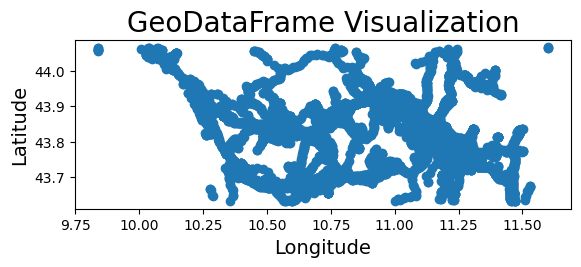

In [223]:
import matplotlib.pyplot as plt


plt.figure(figsize=(15, 15))  
gdf.head(10000).plot()

plt.title("GeoDataFrame Visualization", fontsize=20)
plt.xlabel("Longitude", fontsize=14)
plt.ylabel("Latitude", fontsize=14)

plt.show()

In [14]:
for date, gdf in gdfs.items():
    print(f"GeoDataFrame for date: {date}")
    print("First row of the GeoDataFrame:")
    print(gdf.head(1))
    print("\nGeoDataFrame Info:")
    gdf.info()  # info fa già il print
    print("\nCoordinate Reference System (CRS):")
    print(gdf.crs)
    print("\nFirst geometry object:")
    print(gdf.geometry.head(1))
    print("-" * 50)  

GeoDataFrame for date: 20190211
First row of the GeoDataFrame:
    0           1         2          3          4  5  6  7  8     9  \
0  55  2019-02-09  07:59:17  43.875767  10.800906  0  0  3  2  1038   

                    geometry  
0  POINT (10.80091 43.87577)  

GeoDataFrame Info:
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1025094 entries, 0 to 1025093
Data columns (total 11 columns):
 #   Column    Non-Null Count    Dtype   
---  ------    --------------    -----   
 0   0         1025094 non-null  int64   
 1   1         1025094 non-null  object  
 2   2         1025094 non-null  object  
 3   3         1025094 non-null  float64 
 4   4         1025094 non-null  float64 
 5   5         1025094 non-null  int64   
 6   6         1025094 non-null  int64   
 7   7         1025094 non-null  int64   
 8   8         1025094 non-null  int64   
 9   9         1025094 non-null  int64   
 10  geometry  1025094 non-null  geometry
dtypes: float64(2), geometry(1), int64(6), ob

In [16]:
#Non salvava con colonne numeriche!
for date, gdf in gdfs.items():
    gdf.columns = ['ID', 'Date', 'Time', 'Latitude', 'Longitude', 'Speed', 'Heading', 'Quality', 'PanelSession', 'DeltaPos', 'geometry']
    gdfs[date]= gdf
#ID_ANONYMOUS,DAY,HH24,LATITUDE,LONGITUDE,SPEED,HEADING,QUALITY,ID_PANELSESSION,DELTAPOS
#Ovvero le ultime colonne sono la velocità (km/h, credo) , direzione (gradi, 0 = nord, non mi ricordo se in senso orario), 
#qualità del segnale (è consigliato buttare via quelli < 3), stato del veicolo (0=accensione, 1=in moto, 2=spegnimento), 
#distanza in metri dal punto precedente.

#try:
    #gdf.to_file("PrimoGennaioGPS.geojson", driver="GeoJSON")
    #print("GeoDataFrame saved successfully.")
#except Exception as e:
    #print(f"Error saving GeoDataFrame: {e}")


In [17]:
gdfs['20190211'].head(2)

,ID,Date,Time,Latitude,Longitude,Speed,Heading,Quality,PanelSession,DeltaPos,geometry
0,5514,2019-02-10,14:25:20,43.765483,11.279529,40,80,3,1,429,POINT (11.27953 43.76548)
1,5514,2019-02-10,14:25:57,43.765686,11.281206,0,0,3,1,126,POINT (11.28121 43.76569)


### Filtriamo i valori con qualità segnale <3

In [12]:
for date, gdf in gdfs.items():
    print(date, gdf['Quality'].unique())

20190211 [3 1 2]
20190212 [3 1 2]
20190213 [1 3 2]
20190214 [3 1 2]
20190215 [3 1 2]
20190216 [3 1 2]
20190217 [3 1 2]


In [18]:
for date, gdf in gdfs.items():
    gdf2=gdf[gdf['Quality']==3]
    gdf2=gdf2.drop(columns=['Quality'])
    gdfs[date]=gdf2

In [19]:
for date, gdf in gdfs.items():
    print(len(gdf))

3644
2408
1895
3252
3567
3332
3692
3587
1922
1381
3823
3931
4540
4329
4245
2530
2588
3301
3768
3410
3910
3276
2194
1362
3536
3762
3512
3311


### Filtriamo le date

In [20]:
for date, gdf in gdfs.items():
    unique_dates = gdf['Date'].unique()
    print(f"Unique Dates: in {date}: {unique_dates}")
    data=f"{date[0:4]}-{date[4:6]}-{date[6:8]}"
    gdf3=gdf[gdf['Date']==data]
    gdfs[date]=gdf3

Unique Dates: in 20190201: ['2019-02-01' '2019-01-31' '2019-01-30']
Unique Dates: in 20190202: ['2019-02-01' '2019-02-02']
Unique Dates: in 20190203: ['2019-02-02' '2019-02-03' '2019-02-01' '2019-01-31']
Unique Dates: in 20190204: ['2019-02-03' '2019-02-04' '2019-02-01' '2019-02-02']
Unique Dates: in 20190205: ['2019-02-04' '2019-02-05']
Unique Dates: in 20190206: ['2019-02-06' '2019-02-05']
Unique Dates: in 20190207: ['2019-02-07' '2019-02-06']
Unique Dates: in 20190208: ['2019-02-07' '2019-02-08']
Unique Dates: in 20190209: ['2019-02-08' '2019-02-09']
Unique Dates: in 20190210: ['2019-02-09' '2019-02-10' '2019-02-08']
Unique Dates: in 20190211: ['2019-02-10' '2019-02-11' '2019-02-08' '2019-02-09']
Unique Dates: in 20190212: ['2019-02-11' '2019-02-12']
Unique Dates: in 20190213: ['2019-02-12' '2019-02-13']
Unique Dates: in 20190214: ['2019-02-13' '2019-02-14' '2019-02-12']
Unique Dates: in 20190215: ['2019-02-15' '2019-02-14']
Unique Dates: in 20190216: ['2019-02-15' '2019-02-16']
Uni

In [21]:
for date, gdf in gdfs.items():
    unique_dates = gdf['Date'].unique()
    print(f"Unique Dates: in {date}: {unique_dates}")

Unique Dates: in 20190201: ['2019-02-01']
Unique Dates: in 20190202: ['2019-02-02']
Unique Dates: in 20190203: ['2019-02-03']
Unique Dates: in 20190204: ['2019-02-04']
Unique Dates: in 20190205: ['2019-02-05']
Unique Dates: in 20190206: ['2019-02-06']
Unique Dates: in 20190207: ['2019-02-07']
Unique Dates: in 20190208: ['2019-02-08']
Unique Dates: in 20190209: ['2019-02-09']
Unique Dates: in 20190210: ['2019-02-10']
Unique Dates: in 20190211: ['2019-02-11']
Unique Dates: in 20190212: ['2019-02-12']
Unique Dates: in 20190213: ['2019-02-13']
Unique Dates: in 20190214: ['2019-02-14']
Unique Dates: in 20190215: ['2019-02-15']
Unique Dates: in 20190216: ['2019-02-16']
Unique Dates: in 20190217: ['2019-02-17']
Unique Dates: in 20190218: ['2019-02-18']
Unique Dates: in 20190219: ['2019-02-19']
Unique Dates: in 20190220: ['2019-02-20']
Unique Dates: in 20190221: ['2019-02-21']
Unique Dates: in 20190222: ['2019-02-22']
Unique Dates: in 20190223: ['2019-02-23']
Unique Dates: in 20190224: ['2019-

In [23]:
for date, gdf in gdfs.items():
    print(len(gdf))

817467
826184
849465
884131
890294
819406
679852


In [233]:
#Percentuale dati effettivamente con data giusta
len(gdf3)/len(gdf2)*100

88.4959485248123

### Salvataggio Concatenato

In [23]:
gdfs_commuters = {}
for date, gdf in gdfs.items():
    try:
        gdf['Timestamp'] = gdf['Date'] + ' ' + gdf['Time']
        print(f"{date} {gdf.head(1)}")
        gdfs_commuters[date] = gdf
    except Exception as e:
        print(f"Error processing {date}: {e}")

20190201      ID        Date      Time   Latitude  Longitude  Speed  Heading  \
3  5514  2019-02-01  06:48:47  43.768072  11.287648      4      356   

   PanelSession  DeltaPos                   geometry            Timestamp  
3             1        78  POINT (11.28765 43.76807)  2019-02-01 06:48:47  
20190202      ID        Date      Time   Latitude  Longitude  Speed  Heading  \
9  5514  2019-02-02  08:03:17  43.769671   11.28217     18      312   

   PanelSession  DeltaPos                   geometry            Timestamp  
9             1       185  POINT (11.28217 43.76967)  2019-02-02 08:03:17  
20190203       ID        Date      Time   Latitude  Longitude  Speed  Heading  \
17  5514  2019-02-03  07:04:28  43.767642  11.288583      2      290   

    PanelSession  DeltaPos                   geometry            Timestamp  
17             1         0  POINT (11.28858 43.76764)  2019-02-03 07:04:28  
20190204       ID        Date      Time   Latitude  Longitude  Speed  Heading  \
79 

In [24]:
## salvataggio

import paramiko
import geopandas as gpd
import pandas as pd
import io
# Configurazione
hostname = "kddrtserver10.isti.cnr.it"
username = "avitali"
merged_output_path = "/home/avitali/Commuters_Febbraio2019.geojson"

try:
    #apro connessione ssh
    print("Connecting to SSH server...")
    ssh = paramiko.SSHClient()
    ssh.set_missing_host_key_policy(paramiko.AutoAddPolicy())
    ssh.connect(hostname, username=username)
    print("Connection to SSH server established")

    print("Opening sftp connection...")
    sftp = ssh.open_sftp()
    print("sftp connection opened")

    print("Concatenating gdfs...")
    merged_gdf = gpd.GeoDataFrame(pd.concat(gdfs_commuters.values(), ignore_index=True))
    print(f"Gdfs concatenated and has {len(merged_gdf)} rows")

    print("Saving file...")
    with sftp.open(merged_output_path, "w") as merged_file:
        merged_file.write(merged_gdf.to_json())
        
     
    # Verifica della dimensione del file
    attrs = sftp.stat(merged_output_path)
    print(f"Merged GeoJSON file saved successfully at {merged_output_path}")
    print(f"File size: {attrs.st_size} bytes")


except Exception as e:
    print(f"An error occurred: {e}")

finally:
    #chiudo sdfp e ssh
    try:
        sftp.close()
        ssh.close()
    except Exception as cleanup_error:
        print(f"Error during cleanup: {cleanup_error}")




Connecting to SSH server...
Connection to SSH server established
Opening sftp connection...
sftp connection opened
Concatenating gdfs...
Gdfs concatenated and has 84519 rows
Saving file...
Merged GeoJSON file saved successfully at /home/avitali/Commuters_Febbraio2019.geojson
File size: 27406931 bytes
